In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [5]:
sweep = c.Sweep.load(
    initial_path=initial_path,
    day='0926',
    file_name='sweep_6h_er_Aqm-2',
)
sweep.lists.keys()

dict_keys(['idx', 'repetitions', 'block_n_layers', 'embedding_n_layers', 'ansatz', 'model_uuid', 'best_loss_train', 'best_loss_test', 'loss_validation', 'n_parameters', 'time_train'])

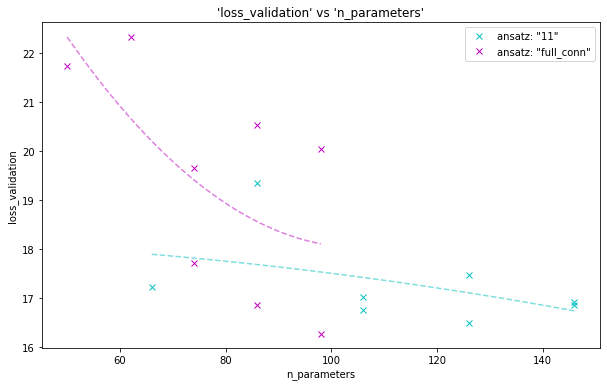

In [13]:
sweep.plot(
    x_key='n_parameters',
    y_key='loss_validation',
    legend_keys=['ansatz'],
    fit_degree=2,
    replace=[("<class 'my_code.quantum_nodes.parts.Ansatz_full_conn'>", 'full_conn'), ("<class 'my_code.quantum_nodes.parts.Ansatz_11'>", '11')],
    fix = [],
    to_string = ['ansatz'],
    colors = [ 'c', 'm', 'y', 'k', 'w'],
)

In [9]:
point = sweep.get_point_min('loss_validation', fix=[('ansatz', "<class 'my_code.quantum_nodes.parts.Ansatz_11'>")], to_string=['ansatz'])

In [10]:
point

{'idx': 13,
 'repetitions': 1,
 'block_n_layers': 3,
 'embedding_n_layers': 1,
 'ansatz': my_code.quantum_nodes.parts.Ansatz_11,
 'model_uuid': UUID('9e7bf383-1a45-4389-ba0b-fded42603e51'),
 'best_loss_train': 17.497654696775257,
 'best_loss_test': 13.340163834008262,
 'loss_validation': 16.496774137435654,
 'n_parameters': 126,
 'time_train': 694.4912073612213}

In [11]:
import csv

def get_results_from_uuid(uuid, file_path):
    with open(file_path, mode='r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['model_uuid'] == uuid:
                day, file_name = row['day'], row['file_name']
                return c.Results.load(
                    initial_path=initial_path,
                    day=day,
                    file_name=file_name,
                )
    
    return None


uuid_to_search = str(point['model_uuid'])
file_path = initial_path + '/saved/results.csv'
results = get_results_from_uuid(uuid_to_search, file_path)

In [28]:
sweep_point = point

# -- QUANTUM BLOCK -- #
n_qubits = 6
quantum_layer = q.circuit(
    n_qubits = n_qubits, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = q.parts.AngleEmbedding,
    embedding_ansatz = sweep_point['ansatz'],
    block_ansatz = sweep_point['ansatz'],
    final_ansatz = sweep_point['ansatz'], 
    measurement = q.parts.Measurement('Z', 'all'),
    embedding_n_layers = sweep_point['embedding_n_layers'],
    different_inputs_per_layer = False,
    block_n_layers = sweep_point['block_n_layers'],
    # wrapper_qlayer = pw.QLayerEmpty,
)

# -- MODEL -- #                    
class Model(m.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
        self.fc2 = m.Reshape()
        self.fc3 = quantum_layer()            
        self.fc4 = m.nn.Linear(n_qubits, 1)

    def forward(self, x):
        for i in [3,4]:
            x = getattr(self, 'fc{}'.format(i))(x)
        return x

model = Model()

model.load_state_dict(results.parameters_epoch.best)

<All keys matched successfully>

In [37]:
model(m.torch.tensor([0, 1, 2, 3, 4, 5], dtype=m.torch.float64))

tensor([-6.1444], grad_fn=<AddBackward0>)

In [92]:
x = m.nn.Parameter(m.torch.randint(0, 18, (n_qubits,), dtype=m.torch.float64) / 18 * 2 * np.pi)

#optime x

n_iter = 1000

optimizer = m.torch.optim.Adam([x], lr=0.5)

model.eval()
last_loss = model(x).item()
for i in range(n_iter):
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()
    print(i, loss.item(), end='\r')
    if abs(last_loss - loss.item()) < 1e-4 and i > 10:
        break
    last_loss = loss.item()

print('final x:', x.detach().numpy().tolist())
print('final loss:', loss.item())
optimized_x = x.detach().numpy().tolist()

final x: [6.211109128538519, 6.2566082177873215, 6.569927409196771, 0.034143888610483425, 5.675355706119033, 0.43927100766416416]
final loss: -25.942463128786645


In [99]:
def to_unique_angles(x):
    return x % (2 * np.pi)

values_embedding = to_unique_angles(model.state_dict()['fc1.weight'].flatten().detach().numpy())
dict_values = dict(zip(values_embedding, list(range(19))))
values_embedding = sorted(values_embedding)
print(values_embedding)

[0.04186966832440037, 0.8625206079326421, 0.9113939180607428, 1.147475523612655, 1.2197345488204578, 1.3078661788176176, 1.3364915961807058, 1.4967349254669495, 1.5313233973379663, 1.5400876805708092, 1.5746278626857533, 1.647315328843031, 4.514381080063097, 4.547593255735803, 4.712198384658065, 4.996700340670205, 5.061909914648007, 5.4714257206792185, 5.545847383622145]


In [100]:
optimized_x = to_unique_angles(np.array(optimized_x))
print(optimized_x)

[6.21110913 6.25660822 5.99644321 0.03414389 5.67535571 0.43927101]


In [101]:
def find_intervals(first_list, second_list):
    results = []
    for num in second_list:
        for i in range(len(first_list) - 1):
            if first_list[i] <= num <= first_list[i + 1]:
                results.append((first_list[i], first_list[i + 1]))
                break
        else:
            # If no interval is found, add the first and last values of the first list.
            results.append((first_list[0], first_list[-1]))
    return results

first_list = [1,2,3,6,7,7.5,8]
second_list = [0.1, 0.5, 6.3, 0.2]

intervals = find_intervals(values_embedding, optimized_x)
possible_inputs = [(dict_values[i],dict_values[j]) for i,j in intervals]


In [102]:
possible_inputs

[(5, 16), (5, 16), (5, 16), (5, 16), (5, 16), (5, 14)]

In [108]:
from itertools import product

combinations = list(product(*possible_inputs))
combinations

[(5, 5, 5, 5, 5, 5),
 (5, 5, 5, 5, 5, 14),
 (5, 5, 5, 5, 16, 5),
 (5, 5, 5, 5, 16, 14),
 (5, 5, 5, 16, 5, 5),
 (5, 5, 5, 16, 5, 14),
 (5, 5, 5, 16, 16, 5),
 (5, 5, 5, 16, 16, 14),
 (5, 5, 16, 5, 5, 5),
 (5, 5, 16, 5, 5, 14),
 (5, 5, 16, 5, 16, 5),
 (5, 5, 16, 5, 16, 14),
 (5, 5, 16, 16, 5, 5),
 (5, 5, 16, 16, 5, 14),
 (5, 5, 16, 16, 16, 5),
 (5, 5, 16, 16, 16, 14),
 (5, 16, 5, 5, 5, 5),
 (5, 16, 5, 5, 5, 14),
 (5, 16, 5, 5, 16, 5),
 (5, 16, 5, 5, 16, 14),
 (5, 16, 5, 16, 5, 5),
 (5, 16, 5, 16, 5, 14),
 (5, 16, 5, 16, 16, 5),
 (5, 16, 5, 16, 16, 14),
 (5, 16, 16, 5, 5, 5),
 (5, 16, 16, 5, 5, 14),
 (5, 16, 16, 5, 16, 5),
 (5, 16, 16, 5, 16, 14),
 (5, 16, 16, 16, 5, 5),
 (5, 16, 16, 16, 5, 14),
 (5, 16, 16, 16, 16, 5),
 (5, 16, 16, 16, 16, 14),
 (16, 5, 5, 5, 5, 5),
 (16, 5, 5, 5, 5, 14),
 (16, 5, 5, 5, 16, 5),
 (16, 5, 5, 5, 16, 14),
 (16, 5, 5, 16, 5, 5),
 (16, 5, 5, 16, 5, 14),
 (16, 5, 5, 16, 16, 5),
 (16, 5, 5, 16, 16, 14),
 (16, 5, 16, 5, 5, 5),
 (16, 5, 16, 5, 5, 14),
 (16, 5, 16, 

In [110]:
best_combination = None
best_value = 0
for comb in combinations:
    score = model(m.torch.tensor(comb, dtype=m.torch.float64)).item()
    if score < best_value:
        best_combination = comb
        best_value = score
    print(comb, score)

(5, 5, 5, 5, 5, 5) -6.450100583074978
(5, 5, 5, 5, 5, 14) -4.398180885619367
(5, 5, 5, 5, 16, 5) 2.9522464996031146
(5, 5, 5, 5, 16, 14) 3.832131541372411
(5, 5, 5, 16, 5, 5) -4.952148333386784
(5, 5, 5, 16, 5, 14) -4.643211829167926
(5, 5, 5, 16, 16, 5) 0.5101970471858035
(5, 5, 5, 16, 16, 14) 1.374868577581696
(5, 5, 16, 5, 5, 5) -3.5819099125452603
(5, 5, 16, 5, 5, 14) -1.105972618277581
(5, 5, 16, 5, 16, 5) 5.510436338555506
(5, 5, 16, 5, 16, 14) 6.390421205601127
(5, 5, 16, 16, 5, 5) -5.148461951954429
(5, 5, 16, 16, 5, 14) -4.819736661837201
(5, 5, 16, 16, 16, 5) 0.4370873505864936
(5, 5, 16, 16, 16, 14) 1.341601834745887
(5, 16, 5, 5, 5, 5) -3.8712171539076223
(5, 16, 5, 5, 5, 14) -2.1184164221090427
(5, 16, 5, 5, 16, 5) 6.9359180367055
(5, 16, 5, 5, 16, 14) 7.763981005035545
(5, 16, 5, 16, 5, 5) -3.0258820276709866
(5, 16, 5, 16, 5, 14) -3.1063488166844446
(5, 16, 5, 16, 16, 5) 0.955929662013415
(5, 16, 5, 16, 16, 14) 1.098181437043745
(5, 16, 16, 5, 5, 5) -1.6189147925081693
(

In [111]:
best_combination, best_value

((16, 16, 5, 16, 5, 5), -12.099782118838643)